# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for XResNet
from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
from nb_new_data_augmentation import *

In [4]:
import pdb

In [5]:
__version__

'1.0.55'

# 6D image test

In [6]:
class Image6D(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()

In [7]:
def open_image_6D(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6D,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
            
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x)

In [8]:
#PATH_trunc = 'train/HEPG2-01/Plate1/B02_s1' # path is missing suffix "_w1.png"
#open_image_6D(PATH_trunc)

# Dataset setup

In [9]:
class ImageList6D(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6D(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [10]:
#def show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
#                alpha:float=None, **kwargs)->plt.Axes:
#    "Display `Image` in notebook."
#    if ax is None: fig,ax = plt.subplots(figsize=figsize)
#    pdb.set_trace()
#    #ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha, **kwargs)
#    ax.imshow(np.concatenate((image2np(self.px[:3]),
#                              image2np(self.px[3:])), axis=1),
#              cmap=cmap, alpha=alpha, **kwargs)
#    if hide_axis: ax.axis('off')
#    return ax


## Full dataset

### Dataset parameters full dataset

In [11]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v1_20190714.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v1_20190714.csv', index_col=0)

In [12]:
df_train.head()

,path,experiment,sirna,multi,valid
0,HEPG2-01/Plate1/B03_s1,HEPG2-01,513,HEPG2-01 513,0
1,HEPG2-01/Plate1/B04_s1,HEPG2-01,840,HEPG2-01 840,0
2,HEPG2-01/Plate1/B05_s1,HEPG2-01,1020,HEPG2-01 1020,0
3,HEPG2-01/Plate1/B06_s1,HEPG2-01,254,HEPG2-01 254,0
4,HEPG2-01/Plate1/B07_s1,HEPG2-01,144,HEPG2-01 144,0


In [13]:
df_test.head()

,path,experiment
0,HEPG2-08/Plate1/B03_s1,HEPG2-08
1,HEPG2-08/Plate1/B04_s1,HEPG2-08
2,HEPG2-08/Plate1/B05_s1,HEPG2-08
3,HEPG2-08/Plate1/B06_s1,HEPG2-08
4,HEPG2-08/Plate1/B07_s1,HEPG2-08


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [14]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [15]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [16]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [17]:
## ResNet50pt
#sz, bs = 96, 8*46 # 77560MiB /  7952MiB

## XResNet50c
#sz, bs = 96, 8*46 # 7573MiB /  7952MiB
#sz, bs = 128, 8*52 # 7935MiB /  7952MiB
#sz, bs = 256, 8*13 # 7929MiB /  7952MiB
#sz, bs = 512, 8*3 # 7575MiB /  7952MiB

## XResNet50c AdaCos
#sz, bs = 128, 8*50 # 7846MiB /  7952MiB

## XResNet152fh
#sz, bs = 128, 8*23 # 7919MiB /  7952MiB

## SE_XResNet152fh
#sz, bs = 128, 8*18 # 7752MiB /  7952MiB
#sz, bs = 256, 8*4 # 7639MiB /  7952MiB
#sz, bs = 512, 8 #


## AdaCos-SE-XResNet50c
#sz, bs = 128, 8 # TEST
#sz, bs = 128, 8*20 # 7430MiB /  7952MiB --> FP32 !!!
sz, bs = 256, 8*5 # 7475MiB /  7952MiB
#sz, bs = 512, 8*3 #

In [18]:
sz, bs

(256, 40)

In [19]:
# normal tfms
#tfms = get_transforms()

# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=color_augmentation())

In [20]:
# future transform mix?

### Full dataset

In [21]:
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3) # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [22]:
data

ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: EmptyLabelList
,,,,
Path: train

In [23]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [24]:
data.train_ds[0]

(Image6D (6, 128, 128), Category 513)

In [25]:
#data.classes

In [26]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 513)

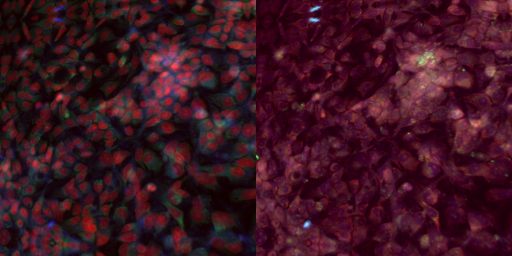

In [23]:
data.train_ds[0][0]

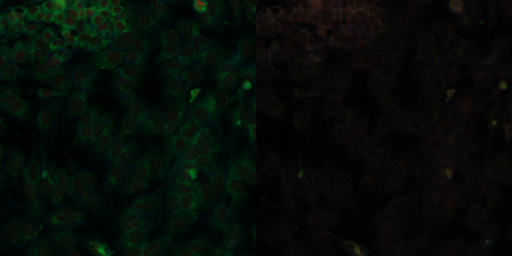

In [24]:
data.test_ds[0][0]

### Adversarial full dataset

In [32]:
data_a = (ImageList6D.from_df(df_train, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_train, path='train'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [282]:
data_a

ImageDataBunch;

Train: LabelList (33191 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
HEPG2-01;513,HEPG2-01;840,HEPG2-01;1020,HEPG2-01;254,HEPG2-01;144
Path: train;

Valid: LabelList (3324 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
267,768,632,86,1051
Path: train;

Test: None

In [283]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

(1138, 1138, ['RPE-03', 'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07'])

In [284]:
data_a.batch_size

208

In [285]:
data_a.train_ds[0]

(Image6D (6, 128, 128), MultiCategory HEPG2-01;513)

In [286]:
#data_a.classes

In [287]:
data_a.train_ds[0][1], data_a.train_ds[0][1].data

(MultiCategory HEPG2-01;513,
 array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32))

In [288]:
data_a.train_ds[0][1].data.sum()

2.0

In [289]:
np.where(data_a.train_ds[0][1].data > 0.5)

(array([ 569, 1108]),)

In [290]:
[data_a.classes[j] for j in np.where(data_a.train_ds[0][1].data > 0.5)[0]]

['513', 'HEPG2-01']

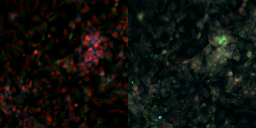

In [291]:
data_a.train_ds[0][0]

In [292]:
# DOES NOT WORK?
#data_a.train_ds[0][0].show()

# Model setup

## SE-XResNet152Feature+Head

SE-XResNet152Feature model including AdaptiveConcatPool2d stage + normal fastai head

In [ ]:
# Check regularly for improvments: https://github.com/fastai/fastai_dev/blob/master/dev/60_vision_models_xresnet.ipynb

In [22]:
# from https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py#L85
class SE_Module(Module): # change nn.Module to Module

    def __init__(self, channels, reduction=16):
        #super(SE_Module, self).__init__() # not needed?
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

In [23]:
# fastai resblock combined with SEModule
class SE_ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        #self.convs = nn.Sequential(*layers) # without SEModule
        self.convs = nn.Sequential(*layers, SE_Module(nf))
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [24]:
class SE_XResNetFeature(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6):#, c_out=1108):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            AdaptiveConcatPool2d(), Flatten(),
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            # remove head:
            #nn.Linear(block_szs[-1]*expansion, c_out)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[SE_ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [25]:
se_xresnet152f = SE_XResNetFeature(4, [3,8,36,3], c_in=6) #, c_out=1108)

In [26]:
#se_xresnet152f

In [27]:
se_xresnet152f(torch.randn(1,6,512,512)).shape

torch.Size([1, 4096])

In [28]:
se_xresnet152f(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 4096])

### Head

In [29]:
#AdaptiveConcatPool2d()

In [30]:
#create_head(nf=4*512, nc=1108)

In [31]:
se_xresnet152f_head = create_head(nf=4*512*2, nc=1108)[2:]

In [32]:
se_xresnet152 = nn.Sequential(se_xresnet152f, se_xresnet152f_head)

In [33]:
se_xresnet152(torch.randn(2,6,512,512)).shape

torch.Size([2, 1108])

## SE-XResNet50Feature+AdaCos-Head

SE-XResNet152Feature model including AdaptiveConcatPool2d stage + normal fastai head

In [22]:
# Check regularly for improvments: https://github.com/fastai/fastai_dev/blob/master/dev/60_vision_models_xresnet.ipynb

In [25]:
# from https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py#L85
class SE_Module(Module): # change nn.Module to Module

    def __init__(self, channels, reduction=16):
        #super(SE_Module, self).__init__() # not needed?
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

In [26]:
# fastai resblock combined with SEModule
class SE_ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        #self.convs = nn.Sequential(*layers) # without SEModule
        self.convs = nn.Sequential(*layers, SE_Module(nf))
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [27]:
class SE_XResNetFeature(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6):#, c_out=1108):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            #AdaptiveConcatPool2d(), Flatten(),
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            # remove head:
            #nn.Linear(block_szs[-1]*expansion, c_out)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[SE_ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [28]:
#se_xresnet152f = SE_XResNetFeature(4, [3,8,36,3], c_in=6) #, c_out=1108)
se_xresnet50f = SE_XResNetFeature(4, [3,4,6 ,3], c_in=6) #, c_out=1108)

In [29]:
#se_xresnet152f

In [30]:
#se_xresnet50f(torch.randn(1,6,sz,sz)).shape

In [31]:
#se_xresnet50f(data.train_ds[0][0].data.unsqueeze(0)).shape

### AdaCos-Head

In [32]:
def create_adacos_head(nf:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                concat_pool:bool=True, bn_final:bool=False):
    #nc:int, 
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, 512] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    #layers.append(AdaCos(lin_ftrs[-1], nc))
    return nn.Sequential(*layers)

In [33]:
adacos_head = create_adacos_head(nf=4*512*2)#, nc=1108)

In [34]:
#adacos_head

In [35]:
#adacos_head(torch.randn(2, 2048, 4, 4)).shape

In [36]:
# from https://github.com/4uiiurz1/pytorch-adacos/blob/master/metrics.py
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, xb, yb):
        
        #print(yb.shape)
        #pdb.set_trace()
        
        # normalize features
        x = F.normalize(xb)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        
        #if yb is None:
        #    return logits
        
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits)
        
        #one_hot.scatter_(1, yb.view(-1, 1).long(), 1)
        #one_hot.scatter_(1, torch.tensor(yb).view(-1,1).long(), 1)
        one_hot.scatter_(1, yb.view(-1,1).long(), 1)
        
        with torch.no_grad():
            B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
            B_avg = torch.sum(B_avg) / xb.size(0)
            #print(B_avg)
            theta_med = torch.median(theta[one_hot == 1])
            self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
            #print(self.s)
        output = self.s * logits

        return output

In [37]:
class AdaCosNet(nn.Module):
    '''Simple AdaCosNet connecter to run xb through the feature extractor head
    and then feed xb and yb into the AdaCos layer.'''
    def __init__(self, body, head):
        super(AdaCosNet, self).__init__()
        self.body = body
        self.head = head
        self.adacos = AdaCos(512, 1108)
        
    def forward(self, xb, yb):
        features = self.body(xb)
        out = self.head(features)
        #print('xb.shape: ', xb.shape,', yb.shape: ', yb.shape)
        out = self.adacos(out, yb)
        #print('out: ',out.shape)
        #pdb.set_trace()
        return out

In [38]:
adacos_se_xresnet50c = AdaCosNet(se_xresnet50f, adacos_head)

In [39]:
adacos_se_xresnet50c(torch.randn(2,6,sz,sz), torch.tensor([513, 1])).shape

torch.Size([2, 1108])

In [38]:
#xb, yb = next(iter(data.train_dl))

In [39]:
#xb.shape, yb.shape

In [40]:
#adacos_se_xresnet50c.cuda();

In [41]:
#adacos_se_xresnet50c(xb,yb).shape

In [42]:
#adacos_se_xresnet50c(xb,yb)

In [40]:
# Based on https://forums.fast.ai/t/teacher-forcing/29415/4
# https://forums.fast.ai/t/on-batch-begin-callback/35201/3
@dataclass
class AppendBatchTargs(Callback):
    learn:Learner
    def __init__(self, learn):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target':last_target}

In [38]:
#@dataclass
#class AppendBatchTargs(LearnerCallback):
#    def __init__(self, learn:Learner):
#        super().__init__()
#    def on_batch_begin(self, last_input, last_target, **kwargs):
#        return {'last_input':(last_input, last_target), 'last_target':last_target}

# Training

## xresnet152fh

In [34]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [ ]:
learn = Learner(data, xresnet152, metrics=[accuracy], callback_fns=[CSVLogger]).to_fp16()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [42]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.107021,7.028034,0.000517,03:01
1,7.031340,6.902747,0.002197,03:01
2,6.893337,6.803727,0.003489,03:02
3,6.793570,6.793468,0.004523,03:05


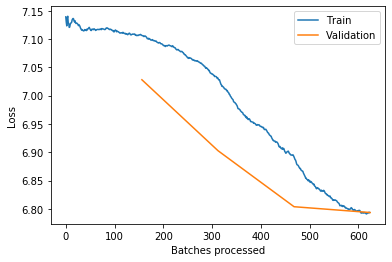

In [43]:
learn.recorder.plot_losses()

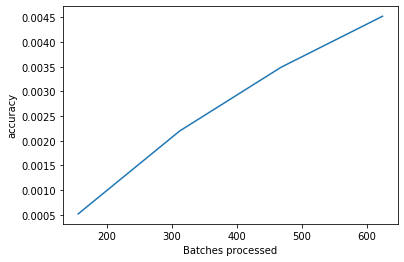

In [44]:
learn.recorder.plot_metrics()

In [45]:
#learn.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-05


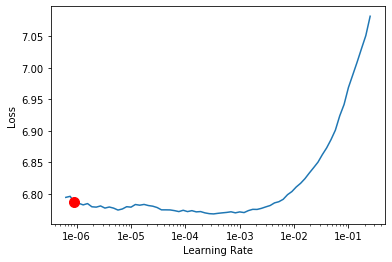

In [46]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [47]:
learn.fit_one_cycle(16, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.780805,6.793058,0.005169,03:03
1,6.768823,6.768906,0.003102,03:04
2,6.762675,6.757470,0.003619,03:05
3,6.722799,6.747814,0.004523,03:03
4,6.646468,6.720433,0.003877,03:03
5,6.549493,6.653822,0.007108,03:04
6,6.457099,6.573979,0.006720,03:02
7,6.357457,6.596412,0.008012,03:05
8,6.238839,6.552967,0.010597,03:04
9,6.105408,6.410344,0.012794,03:06


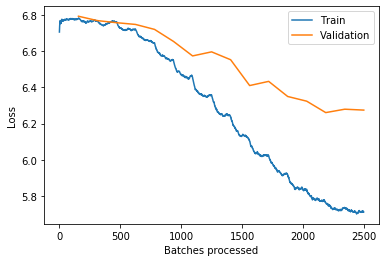

In [48]:
learn.recorder.plot_losses()

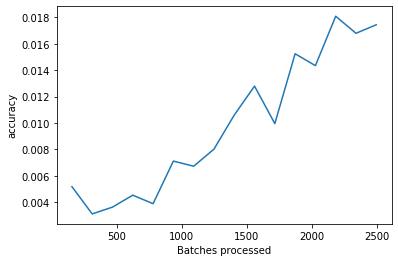

In [49]:
learn.recorder.plot_metrics()

In [50]:
learn.save('xresnet152fh_val-split-ex-v1_128px_e020_20190721', return_path=True)

PosixPath('train/models/xresnet152fh_val-split-ex-v1_128px_e020_20190721.pth')

In [51]:
learn.load('xresnet152fh_val-split-ex-v1_128px_e020_20190721');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 4.37E-06


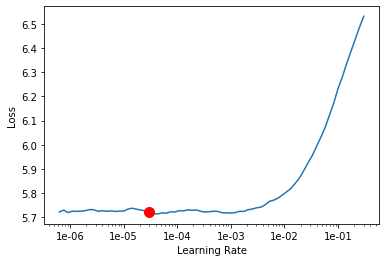

In [52]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [53]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.736735,6.271913,0.016542,03:04
1,5.750206,6.237713,0.018609,03:06
2,5.764630,6.275198,0.017446,03:07
3,5.782061,6.317126,0.016542,03:04
4,5.794617,6.307801,0.018609,03:05
5,5.725820,6.201957,0.019514,03:04
6,5.654782,6.325262,0.017317,03:04
7,5.556430,6.275567,0.019643,03:05
8,5.425997,6.191385,0.031016,03:06
9,5.312214,6.017239,0.030757,03:05


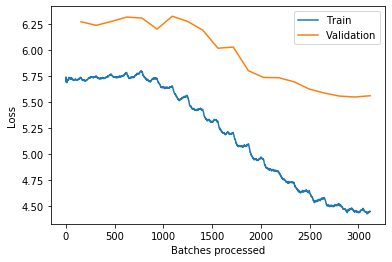

In [54]:
learn.recorder.plot_losses()

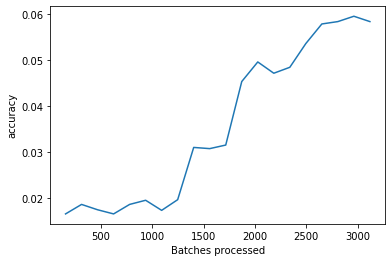

In [55]:
learn.recorder.plot_metrics()

In [56]:
learn.save('xresnet152fh_val-split-ex-v1_128px_e040_20190721', return_path=True)

PosixPath('train/models/xresnet152fh_val-split-ex-v1_128px_e040_20190721.pth')

In [57]:
learn.load('xresnet152fh_val-split-ex-v1_128px_e040_20190721');

In [58]:
# switch to mixup
learn.mixup();

Learner(data=ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: EmptyLabelList
,,,,
Path: train, model=Sequential(
  (0): XResNetFeature(
    (0): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.20E-04


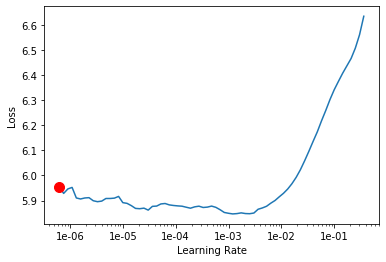

In [59]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [60]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.631413,5.759766,0.046782,03:03
1,5.698930,5.829951,0.042905,03:05
2,5.734103,6.042806,0.035539,03:05
3,5.661202,6.004486,0.042130,03:08
4,5.566839,5.695405,0.050530,03:03
5,5.456644,5.619204,0.055441,03:03
6,5.324374,5.481314,0.063970,03:05
7,5.251019,5.467087,0.067718,03:06


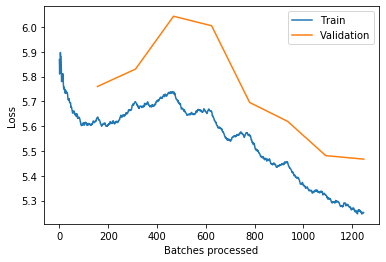

In [61]:
learn.recorder.plot_losses()

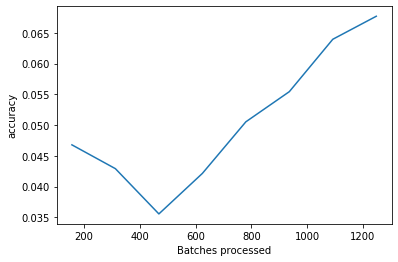

In [62]:
learn.recorder.plot_metrics()

In [66]:
learn.save('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e048_20190721', return_path=True)

PosixPath('train/models/resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e048_20190721.pth')

In [67]:
learn.load('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e048_20190721');

In [69]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.304587,5.520511,0.064099,03:07
1,5.464979,5.687278,0.052985,03:05
2,5.557710,5.698963,0.052985,03:05
3,5.477211,5.737346,0.053502,03:04
4,5.386480,5.441889,0.064228,03:05
5,5.241515,5.463047,0.067976,03:05
6,5.103537,5.368401,0.076764,03:07
7,5.066922,5.305137,0.082450,03:05


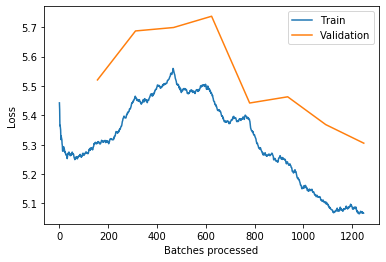

In [70]:
learn.recorder.plot_losses()

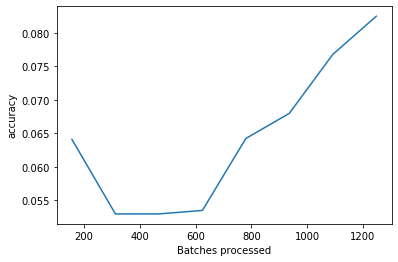

In [71]:
learn.recorder.plot_metrics()

In [72]:
learn.save('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e056_20190721', return_path=True)

PosixPath('train/models/resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e056_20190721.pth')

In [73]:
learn.load('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e056_20190721');

In [74]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.104648,5.319707,0.078056,03:06
1,5.280421,5.891646,0.051305,03:06
2,5.362111,5.830336,0.047428,03:05
3,5.311797,5.679920,0.058671,03:06
4,5.191258,5.536249,0.068105,03:06
5,5.045655,5.283491,0.086586,03:05
6,4.937920,5.225899,0.093047,03:07
7,4.886864,5.195045,0.095373,03:05


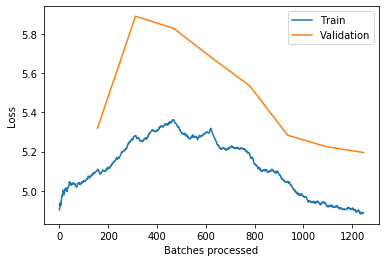

In [75]:
learn.recorder.plot_losses()

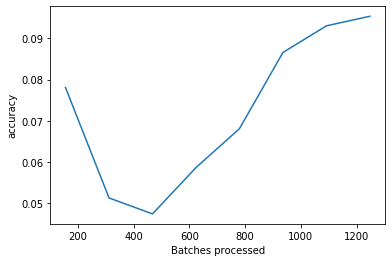

In [76]:
learn.recorder.plot_metrics()

In [77]:
learn.save('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e064_20190721', return_path=True)

PosixPath('train/models/resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e064_20190721.pth')

In [78]:
learn.load('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e064_20190721');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-05


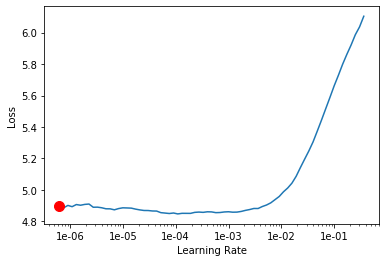

In [79]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [81]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.912584,5.285648,0.087103,03:05
1,5.118741,5.472508,0.078573,03:06
2,5.207138,5.408859,0.075084,03:04
3,5.151009,5.510554,0.069398,03:05
4,5.057180,5.381253,0.081029,03:06
5,4.919106,5.172675,0.096795,03:05
6,4.798452,5.086765,0.102094,03:06
7,4.714162,5.086166,0.102223,03:04


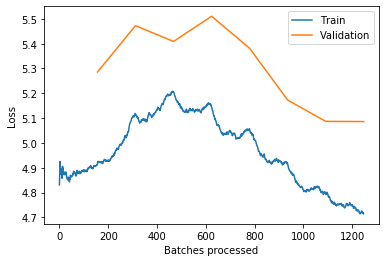

In [82]:
learn.recorder.plot_losses()

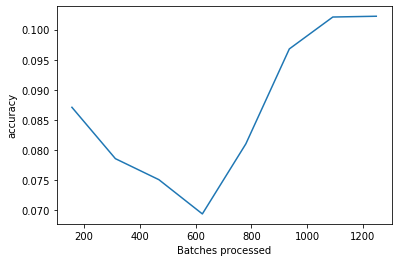

In [83]:
learn.recorder.plot_metrics()

In [84]:
learn.save('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e072_20190721', return_path=True)

PosixPath('train/models/resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e072_20190721.pth')

In [85]:
learn.load('resnet152/xresnet152fh_val-split-ex-v1_128px_mixup_e072_20190721');

## se_xresnet152fh

In [41]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [42]:
learn = Learner(data, adacos_se_xresnet50c, metrics=[accuracy], callback_fns=[CSVLogger, AppendBatchTargs])#.to_fp16()

In [46]:
#learn.opt_func

In [47]:
# Make Adam FP16 proof:
# https://forums.fast.ai/t/mixed-precision-training/29601/21
# https://discuss.pytorch.org/t/adam-half-precision-nans/1765
# https://vxlabs.com/2019/02/04/improving-fastais-mixed-precision-support-with-nvidias-automatic-mixed-precision/
#learn.opt_func = partial(learn.opt_func, eps=1e-4)
#learn.opt_func

### ADD CLIP PARAMETER TOO???

In [43]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

### 128px Standard training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05
Min loss divided by 10: 6.31E-08


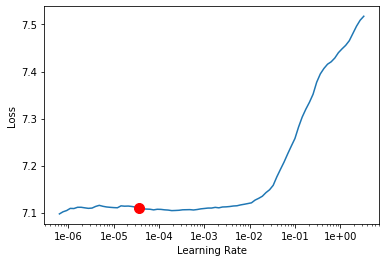

In [49]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [50]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.104717,7.055364,0.001809,03:04
1,7.024161,6.977803,0.003231,03:07
2,6.871113,6.828512,0.003231,03:07
3,6.751935,6.826463,0.004652,03:07


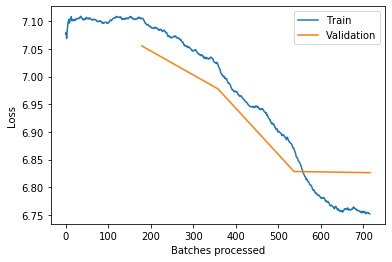

In [51]:
learn.recorder.plot_losses()

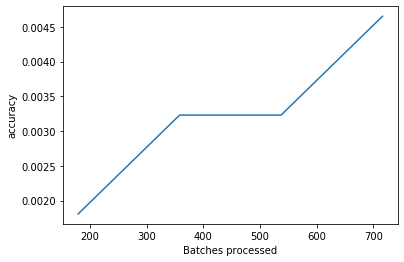

In [52]:
learn.recorder.plot_metrics()

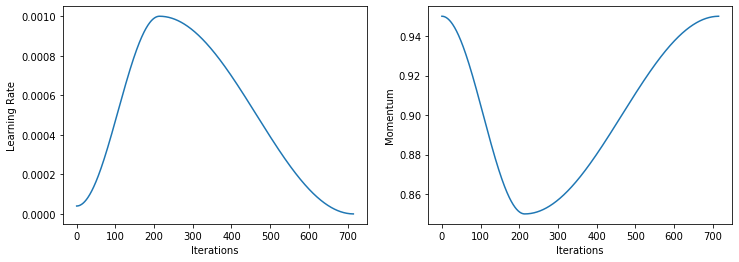

In [53]:
learn.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-07


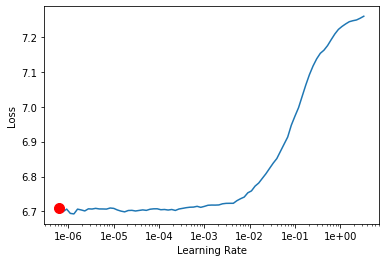

In [54]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [55]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.729484,6.784797,0.004652,03:03
1,6.802896,6.880405,0.003489,03:09
2,6.735397,6.867959,0.003360,03:05
3,6.625309,6.791791,0.004006,03:07
4,6.497015,6.678201,0.005299,03:05
5,6.349478,6.633062,0.007495,03:06
6,6.224877,6.564163,0.008788,03:06
7,6.138471,6.545199,0.008271,03:06


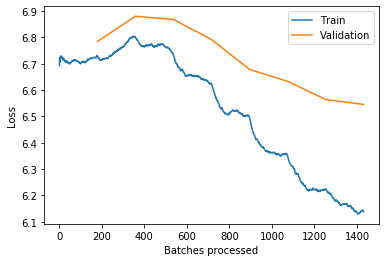

In [56]:
learn.recorder.plot_losses()

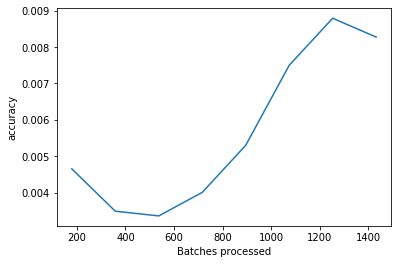

In [57]:
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-05
Min loss divided by 10: 5.75E-05


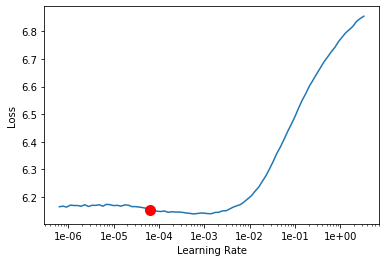

In [58]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [59]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.173625,6.620019,0.008142,03:04
1,6.280900,6.672861,0.006462,03:04
2,6.257083,6.557673,0.009563,03:07
3,6.130602,6.477049,0.011760,03:06
4,5.995426,6.422742,0.011502,03:05
5,5.842599,6.310201,0.015379,03:05
6,5.704380,6.266299,0.017059,03:05
7,5.611087,6.268888,0.017446,03:04


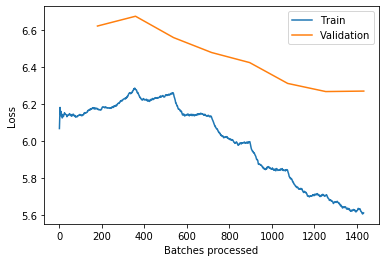

In [60]:
learn.recorder.plot_losses()

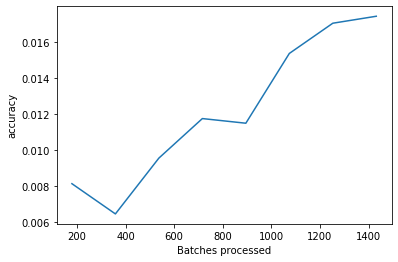

In [61]:
learn.recorder.plot_metrics()

In [62]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-ex-v1_128px_e020_20190723', return_path=True)

PosixPath('train/models/resnet50/adacos_se_xresnet50c_val-split-ex-v1_128px_e020_20190723.pth')

In [63]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-ex-v1_128px_e020_20190723');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-05
Min loss divided by 10: 5.75E-05


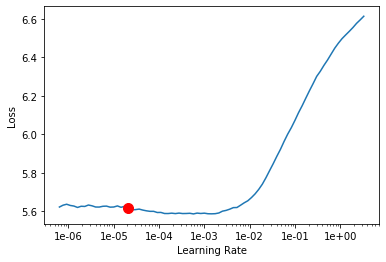

In [64]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [65]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.615267,6.249466,0.018609,03:04
1,5.635270,6.259812,0.017446,03:06
2,5.682876,6.435584,0.011760,03:06
3,5.731081,6.407343,0.015896,03:07
4,5.739407,6.399476,0.013828,03:05
5,5.699776,6.315452,0.018480,03:07
6,5.613810,6.392146,0.019773,03:08
7,5.545374,6.064626,0.024554,03:06
8,5.446128,5.991362,0.027526,03:06
9,5.344337,5.897239,0.034893,03:05


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



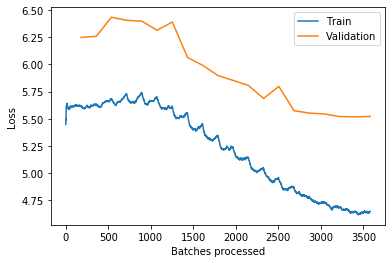

In [66]:
learn.recorder.plot_losses()

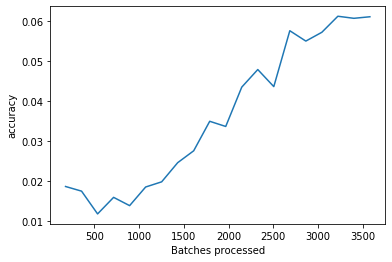

In [67]:
learn.recorder.plot_metrics()

In [68]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-ex-v1_128px_e040_20190723', return_path=True)

PosixPath('train/models/resnet50/adacos_se_xresnet50c_val-split-ex-v1_128px_e040_20190723.pth')

In [69]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-ex-v1_128px_e040_20190723');

### Over night

In [70]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss', patience=8)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='resnet50/adacos_se_xresnet50c_val-split-ex-v1_128px_e040-200_20190723_best')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 3.98E-07


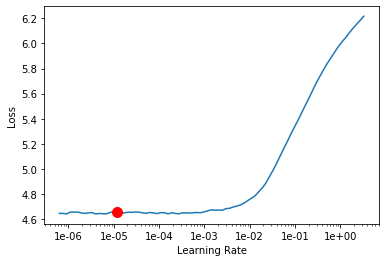

In [71]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [72]:
learn.fit(160, lr=1e-3, callbacks=[savem, redlr])

epoch,train_loss,valid_loss,accuracy,time
0,5.032759,5.655125,0.047428,03:03
1,4.970773,5.940760,0.035151,03:06
2,4.941909,5.650648,0.048204,03:07
3,4.878484,5.580300,0.057508,03:08
4,4.834744,5.755776,0.044973,03:06
5,4.808781,5.518294,0.061515,03:07
6,4.752865,5.476137,0.062807,03:08
7,4.707845,5.477857,0.071078,03:09
8,4.661770,5.432075,0.063970,03:07
9,4.611949,5.503659,0.064616,03:08


Better model found at epoch 0 with accuracy value: 0.047428276389837265.
Better model found at epoch 2 with accuracy value: 0.04820366948843002.
Better model found at epoch 3 with accuracy value: 0.057508401572704315.
Better model found at epoch 5 with accuracy value: 0.06151460483670235.
Better model found at epoch 6 with accuracy value: 0.06280692666769028.
Better model found at epoch 7 with accuracy value: 0.07107780128717422.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 50 with accuracy value: 0.14241406321525574.
Epoch 52: reducing lr to 0.0002
Better model found at epoch 53 with accuracy value: 0.15146031975746155.
Better model found at epoch 54 with accuracy value: 0.163091242313385.
Epoch 99: reducing lr to 6.400000000000003e-08


KeyboardInterrupt: 

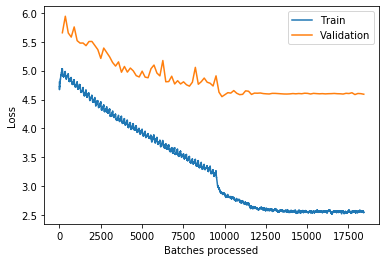

In [73]:
learn.recorder.plot_losses()

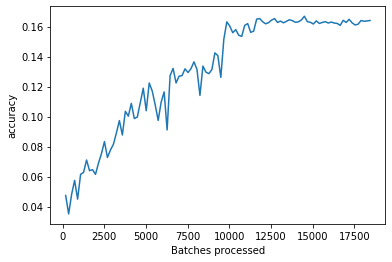

In [74]:
learn.recorder.plot_metrics()

In [ ]:
# Best model save as "adacos_se_xresnet50c_val-split-ex-v1_128px_e040-143_20190723_best"!

In [75]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-ex-v1_128px_e143_20190723', return_path=True)

PosixPath('train/models/resnet50/adacos_se_xresnet50c_val-split-ex-v1_128px_e143_20190723.pth')

In [44]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-ex-v1_128px_e143_20190723');

### 256px Standard training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 5.25E-04


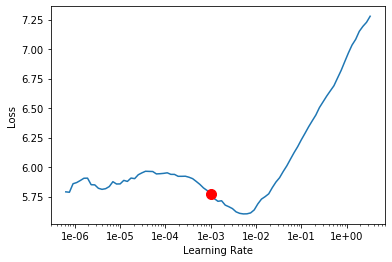

In [45]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [46]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.947112,4.962834,0.112432,05:44
1,3.965914,4.733676,0.140088,05:43
2,3.554372,4.509617,0.175239,05:45
3,3.232993,4.399100,0.186482,05:44


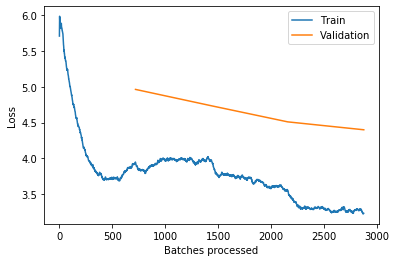

In [47]:
learn.recorder.plot_losses()

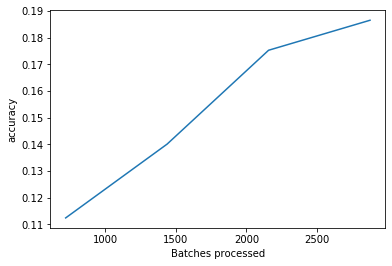

In [48]:
learn.recorder.plot_metrics()

In [49]:
#learn.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 2.75E-07


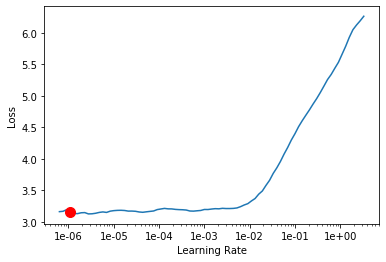

In [50]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.293216,4.476551,0.180408,05:41
1,3.820862,4.746135,0.144482,05:44
2,3.869327,4.608175,0.161411,05:46
3,3.849073,4.820482,0.136469,05:45
4,3.603731,4.532677,0.166322,05:45
5,3.370605,4.449434,0.192427,05:42


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-ex-v1_256px_e012_20190724', return_path=True)

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-ex-v1_256px_e012_20190724');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(8, max_lr=1e-3)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-ex-v1_256px_e020_20190724', return_path=True)

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-ex-v1_256px_e020_20190724');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(20, max_lr=1e-3)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-ex-v1_256px_e040_20190724', return_path=True)

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-ex-v1_256px_e040_20190724');

### Over day

In [ ]:
redlr = ReduceLROnPlateauCallback(learn, monitor='accuracy', patience=8)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='resnet50/adacos_se_xresnet50c_val-split-ex-v1_256px_e040-140_20190724_best')


In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit(100, lr=1e-3, callbacks=[savem, redlr])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-ex-v1_256px_e140_20190724', return_path=True)

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-ex-v1_256px_e140_20190724');

# Submission

## Get predicitions

In [49]:
model = 'se_xresnet152fh_val-split-ex-v1_cutmix_128e300_256e064_512e020_20190723'

In [58]:
#learn.load('resnet152/'+model)

Learner(data=ImageDataBunch;

Train: LabelList (28777 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (7738 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (19897 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: EmptyLabelList
,,,,
Path: train, model=Sequential(
  (0): SE_XResNetFeature(
    (0): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [50]:
# get prediction of test dataset
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [51]:
# check length
len(preds)

19897

In [52]:
#preds

In [53]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [54]:
# get the names
preds_names = learn.data.test_ds.x.items

In [55]:
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]
# including sX
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [56]:
df_preds = pd.DataFrame({'id_code': preds_names, 'sirna': preds.argmax(dim=-1)})

In [57]:
df_preds.head()

,id_code,sirna
0,HEPG2-08_1_B03,132
1,HEPG2-08_1_B04,445
2,HEPG2-08_1_B05,132
3,HEPG2-08_1_B06,577
4,HEPG2-08_1_B07,132


In [58]:
df_preds.to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [59]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 55.3k/55.3k [00:02<00:00, 19.3kB/s]
Successfully submitted to Recursion Cellular Image Classification

### TTA

In [ ]:
# get TTA prediction of test dataset
learn.to_fp32();
preds, _ = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
# check length
len(preds)

In [ ]:
#preds

In [ ]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [ ]:
# get the names
preds_names = learn.data.test_ds.x.items

In [ ]:
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]
# including sX
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [ ]:
df_preds = pd.DataFrame({'id_code': preds_names, 'sirna': preds.argmax(dim=-1)})

In [ ]:
df_preds.head()

In [ ]:
df_preds.to_csv('sub/'+model+'_TTA.csv.gz', index=False, compression='gzip')

In [ ]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}_TTA.csv.gz -m "{model}"


# Others

## Callback

In [ ]:
# https://docs.fast.ai/callback.html#callback

In [ ]:
# https://docs.fast.ai/callbacks.general_sched.html
def grl_scheduling(learn, n_cycles):
    '''Gradient reversal layer scheduling'''
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n).schedule_hp('grl_factor', grl, anneal=annealing_cos))
              for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    #learn. ??
    
    #if cycle_mult != 1:
    #    total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    #else: total_epochs = n_cycles * cycle_len
    #learn.fit(total_epochs)

In [ ]:
# https://docs.fast.ai/callback.html#OptimWrapper
# OptimWrapper needed with the 'grl' parameter?

In [ ]:
# Einfacher Callback mit nur 'on_train_begin'???

# Oder besser (?): monkey-patch optimizer mit 'grl' Variable
# und dann Adaptierung der 'grl_scheduling' Funktion!